# Physical Implementation

Quantum computers are _real_ quantum systems that we wish to design and control. Moreover, quantum computers face quite the conflicting requirements: on one hand we wish to interact with the system to control and measure it; but on the other hand we wish to protect the system from the environment. None the less, experimental realizations of quantum computers has made significant progress in the past two decades.

## Superconducting Qubits

In [1]:
import matplotlib.pyplot as plt
import numpy as np

The Cooper Pair Box (CPB) Hamiltonian is:

$$
H_T = H_{el} + H_j
$$

where $H_{el}$ is the electrostatic component and $H_j$ is the nonlinear Josephson junction component. These can be written as:

$$
H_{el} = 4E_C(\hat{n} - n_g)^2 \approx \sum_n 4E_C(n - n_g)^2 |n\rangle\langle n|
$$

$$
H_j = -\frac{E_j}{2} \cos \hat {\theta} \approx -\frac{E_j}{2} \sum_n |n\rangle\langle n+1| + |n+1\rangle\langle n|
$$

where $E_j$ is the Josephson energy of the junction, and $E_c$ is the charging energy inversely proportional to the total capacitance of the qubit circuit.


This Hamiltonian is written in the basis of charge eigenstates, which is associated with the number $\hat{n}$ of Cooper pairs.

As a matrix, the Hamiltonian looks like 

$$
H = \begin{pmatrix}
4 E_c (-n)^2 & - \frac{E_j}{2} & & &  \\
- \frac{E_j}{2} & 4 E_c (-n+1)^2 & - \frac{E_j}{2} & & \\
& - \frac{E_j}{2} & 4 E_c (-n+2)^2 & - \frac{E_j}{2} & \\
& & & & \ddots
\end{pmatrix}
$$

The eigenvector relation 

$$
H \psi_i = E_i \psi_i
$$

gives us

$$
- \frac{E_j}{2} \psi_{i, r-1} + (n - r)^2 \psi_{i, r} - \frac{E_j}{2} \psi_{i, r+1} = E_i \psi_i
$$

with boundary condition: $\psi_0 = \psi_{r+1} = 0$.


### The Hamiltonian in Phase Basis

The operator conjugated to $\hat{n}$ is the superconducting phase $\hat{\theta}$:

$$
\hat{\theta}|\theta \rangle = \theta |\theta\rangle
$$

where there is a circular topology:

$$
|\theta\rangle = |\theta + 2\pi\rangle
$$

The set $\{|\theta\rangle, \theta \in [0, 2\pi]\}$ for a complete basis.

$$
\hat{n} = \frac{1}{i}\frac{\partial}{\partial \theta}
$$


The $\hat{\phi}$ is superconducing phase difference which satisfies the commutation relation with $\hat{N}$: 

$$
[\hat{\phi}, \hat{n}] = i
$$

In the phase representation the Hamiltonian can be written as:

$$
\left[ -4 E_C \frac{\partial^2}{\partial \phi^2} - E_J \cos \phi\right] \psi(\phi) = E\psi(\phi)
$$

Where $\phi$ must satisfy boundary conditions: $\phi(\theta) = \phi(\theta + 2\pi)$. This has the form of a Mathieu differential equation, which has known analytical solutions using Mathieu functions.

The eigenvalues are:

$$
E_n = E_C M_a(\mu_n, -\frac{E_J}{2E_C})
$$

### Fitting the Hamiltonian

In reality, once a superconducting chip is built, we do not have access to what the values of $E_j$ and $E_c$ are and therefore we must recover them. What we do have access to the is _frequencies_ (_energies_) of the qubit.

As a first step, we can approximate $E_c$ and $E_j$ using the first three _transition_ frequencies

- $w_{01} = E_1 - E_0$
- $w_{12} = E_2 - E_1$

$$
\omega_{01} - \omega_{12} = E_C
$$

$$
\omega_{01} = \sqrt{8 E_j E_C} - E_C \Rightarrow E_J = \frac{(w_{01} + E_C)^2}{8E_C}
$$

As an example, let us take the first free energy levels of `ibmq_armonk` and estimate $E_c$ and $E_j$:

In [2]:
freq = [4.80637   , 4.58210259, 4.33777661]
freq = np.array(freq)

E_c = (freq[0] - freq[1])
E_j = (freq[1] + E_c)**2/(8*E_c)
ng = 0

print(f"Approximation for E_c and E_j: {E_c}, {E_j}")

Approximation for E_c and E_j: 0.2242674100000004, 12.875919297023563


#### Optimizing the Fit

Let us try to improve the fit by comparing how close the estimated energies are to the original energies, and then shifting the Hamiltonian parameters.


A helper class computes the Hamiltonian and frequency transitions of a Transmon

In [3]:
class Transmon:
    def __init__(self, n_cut=40):
        self.n_cut = n_cut
        self._n = np.diag(np.arange(-n_cut, n_cut + 1))
        self._hc_n2 = 4 * self._n @ self._n
        self._hc_n1 = -2 * 4 * self._n
        self._hc_n0 = 4 * np.eye(len(self._n))
        self._hj =  -.5 * (np.diag(np.ones(2 * n_cut), 1) + np.diag(np.ones(2 * n_cut), -1))
        
    def __call__(self, ec, ej, ng=0, grad=False, grad_includes_ng=False):
        h = ec * (self._hc_n2 + ng * self._hc_n1 + ng**2 * self._hc_n0) + ej * self._hj
        
        if grad:
            dh_dec = (self._hc_n2 + ng * self._hc_n1 + ng**2 * self._hc_n0)
            dh_dej = self._hj
            if grad_includes_ng:
                dh_dng = ec * (self._hc_n1 + 2 * ng * self._hc_n0)
                grads = np.stack([dh_dec, dh_dej, dh_dng], axis=0)
            else:
                grads = np.stack([dh_dec, dh_dej], axis=0)
            return h, grads
        return h
    
    def transitions(self, ec, ej, ng=0, grad=False, grad_includes_ng=False):
        if grad:
            h, grads = self(ec, ej, ng=ng, grad=grad, grad_includes_ng=grad_includes_ng)
            vals, vecs = np.linalg.eigh(h)
            d_vals = np.einsum('xij,ia,ja->xa', grads, vecs.conj(), vecs)
            return np.diff(vals), np.diff(d_vals, axis=-1)
        return np.diff(np.linalg.eigvalsh(self(ec, ej, ng=ng)))

Now let us optimize

In [4]:
def loss_with_grad(ec_ej_ng):
    t, dt = transmon.transitions(*ec_ej_ng, grad=True, grad_includes_ng=len(ec_ej_ng)==3)
    t = t[:freq.size]
    dt = dt[:, :freq.size]
    r = t - freq
    dr = dt
    loss = r @ r
    grad_loss = 2 * dr @ r
    return loss, grad_loss

transmon = Transmon(40)

x0 = [E_c, E_j, ng]

from scipy.optimize import minimize
result = minimize(loss_with_grad, x0=x0, jac=True)

print(f"Fitted E_c, E_j, and ng: {result.x}")

Fitted E_c, E_j, and ng: [ 2.01700138e-01  1.55999907e+01 -1.37202718e-14]


##### Error Landscape

Let us visualize the error in different Hamiltonian parameters

In [5]:
ec, ej = x0[:2]
EJ = np.linspace(ej * (1 - .9), ej * (1 + .9), 51)
EC = np.linspace(ec * (1 - .9), ec * (1 + .9), 50)
losses = np.zeros((EC.size, EJ.size))
grads = np.zeros((EC.size, EJ.size, 2))
for i, ec in enumerate(EC):
    for j, ej in enumerate(EJ):
        losses[i, j], grads[i, j] = loss_with_grad([ec, ej])

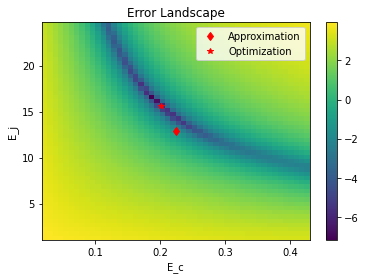

In [6]:
plt.pcolormesh(EC, EJ, np.log(losses.T))
plt.plot(*x0[:2], 'rd', label="Approximation")
plt.plot(*result.x[:2], 'r*', label="Optimization")
plt.xlabel("E_c")
plt.ylabel("E_j")
plt.title("Error Landscape")
plt.colorbar()
plt.legend()
plt.show()

### As a Qubit

We can use the first two levels of the superconducting transmon to be our _qubit_. A key feature is that the energy levels are _anharmonic_, or in other words, the spacing between energy levels varies. This feature is crucial to be able to specifically control the qubit.

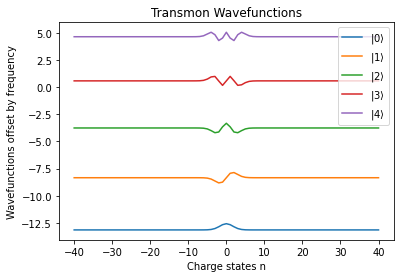

In [7]:
H = transmon(*result.x)

eigs, evecs = np.linalg.eigh(H)

plt.title("Transmon Wavefunctions")

x = range(-transmon.n_cut, transmon.n_cut+1)

plt.plot(x, evecs[:,0] + eigs[0], label=r"$|0\rangle$")
plt.plot(x, evecs[:,1] + eigs[1], label=r"$|1\rangle$")
plt.plot(x, evecs[:,2] + eigs[2], label=r"$|2\rangle$")
plt.plot(x, evecs[:,3] + eigs[3], label=r"$|3\rangle$")
plt.plot(x, evecs[:,4] + eigs[4], label=r"$|4\rangle$")
plt.xlabel("Charge states n")
plt.ylabel("Wavefunctions offset by frequency")
plt.legend()
plt.show()

References:

- Lev Simon Bishop [Thesis](https://arxiv.org/pdf/1007.3520.pdf$$yThesis)

<!-- ```{code-cell} ipython3
# freq = [4.80637   , 4.58210259, 4.33777661]
freq = [3.455869893752602, 3.2467206984967123, 3.011]
transmon = Transmon(freq, method = 'fit')

print(transmon._EC)
print(transmon._EJ)

print(transmon.result)

cs, js, landscape = transmon.get_error_landscape(amount = 10)
cs, js = np.meshgrid(cs, js)

plt.contourf(cs, js, landscape)
plt.colorbar()

print(landscape)

``` -->